<a href="https://colab.research.google.com/github/maderix/python_ray_tracing/blob/master/ray_tracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Ray tracing in python
In computer graphics, ray tracing is a rendering technique for generating an image by tracing the path of light as pixels in an image plane and simulating the effects of its encounters with virtual objects.

![Ray tracing illustration](https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Ray_trace_diagram.svg/450px-Ray_trace_diagram.svg.png)



Ray tracing is a simpler algorithm than rasterization which relies on a complex pipeline of computer graphics techniques and algorithms. While the advantage of Ray tracing are simplicity and ease of implementation, it's notoriously slow compared to rasterization.
In this notebook, we'll attempt to implement a simple ray tracer in Python . Python is not a great choice for such a compute intesive task but as an example, it'll be enough.

In [0]:
#import the required modules
import numpy as np 
#np.seterr(divide='ignore', invalid='ignore')
import math
import cv2
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#a short hand for vector normalization
def normalize(arr):
    #return arr/np.sqrt(arr[0]**2+arr[1]**2+arr[2]**2)
    return arr/np.linalg.norm(arr)

Python natively doesn't have a 3D vector class but as 3D vectors are metrices only, we can use the numpy library to simulate 3D vector math.
Our simple ray tracer will only have spheres. As an extension, more objects can be added later.

In [0]:
#
class Sphere(object):
    def __init__(self, center, radius, surface_color, transparency, reflection,emission_color=np.array([0.0,0.0,0.0])):
        self.center = center
        self.radius = radius
        self.surface_color = surface_color
        self.emission_color = emission_color
        self.transparency = transparency
        self.reflection = reflection
    #intersection routine: Hit a ray with a sphere and return hit points
    def intersect(self, ray_origin, ray_dir):
        l = self.center - ray_origin
        tca = l.dot(ray_dir)
        if tca < 0:
            return False,-1,-1
        d2 = l.dot(l) - tca*tca
        if d2 > self.radius**2:
            return False,-1,-1
        thc = math.sqrt(self.radius**2 - d2)
        t0 = tca - thc
        t1 = tca + thc
        return True,t0,t1

In [0]:
MAX_RAY_DEPTH=5
# a simple routine for mixing two colors
def mix(a,b,mix):
    return b*mix + a*(1-mix)

In [0]:
def ray_trace(ray_origin, ray_dir, spheres, depth):
    tnear = math.inf
    hit = None
    for sphere in spheres:
        status,t0,t1 = sphere.intersect(ray_origin, ray_dir)
        if status:
            if t0 < 0 : t0  = 1
            if t0 < tnear:
                tnear = t0
            hit = sphere
    if hit == None:
        return np.array([0.2,0.2,0.2])
    surface_color = np.array([0.0,0.0,0.0])
    phit = ray_origin + ray_dir * tnear
    nhit = phit - hit.center
    nhit = normalize(nhit)
    # If the normal and the view direction are not opposite to each other
    # reverse the normal direction. That also means we are inside the sphere so set
    # the inside bool to true. Finally reverse the sign of IdotN which we want
    # positive.bias 
    bias = 1e-4
    inside = False
    if ray_dir.dot(nhit) > 0:
        nhit = -1.0 * nhit
        inside = True
    if (hit.transparency > 0 or hit.reflection > 0) and depth < MAX_RAY_DEPTH:
        facing_ratio = -1.0*ray_dir.dot(nhit)
        fresnel_effect = mix(math.pow(1 - facing_ratio, 3), 1, 0.1)
        refl_dir = ray_dir - nhit * 2 * ray_dir.dot(nhit)
        refl_dir = normalize(refl_dir)
        reflection = ray_trace(phit + nhit*bias, refl_dir, spheres, depth + 1)
        refraction = np.array([0.0,0.0,0.0])
        if hit.transparency > 0:
            ior = 1.1
            eta = 0
            if inside:
                eta = ior
            else:
                eta = 1 / ior
            cos_i = -1.0*nhit.dot(ray_dir)
            k = abs(1 - eta * eta * (1 - cos_i**2))
            #print(k)
            sk = math.sqrt(k)
            refr_dir = normalize(ray_dir * eta + nhit * (eta * cos_i - math.sqrt(k) ))
            #print(refr_dir)
            refraction = ray_trace(phit - nhit*bias, refr_dir, spheres, depth + 1)
        surface_color = (reflection * fresnel_effect + 
                        refraction*(1 - fresnel_effect)*hit.transparency) * hit.surface_color
    else:
        surface_color = np.array([0.0,0.0,0.0])
        for i in range(len(spheres)):
            if spheres[i].emission_color[0] > 0:
                transmission = np.array([1.0,1.0,1.0])
                light_dir = spheres[i].center - phit
                light_dir = normalize(light_dir)
                for j in range(len(spheres)):
                    if i != j:
                        t0,t1=0.0,0.0
                        status,t0,t1= spheres[j].intersect(phit + nhit*bias, light_dir)
                        if status:
                            transmission = np.array([0.0,0.0,0.0])
                            break
                surface_color += hit.surface_color * transmission * max(0.0, nhit.dot(light_dir)) * spheres[i].emission_color
                #print(i,surface_color)
    return surface_color + hit.emission_color

In [0]:
def render(spheres):
    height,width = 480,640
    image = np.zeros((height,width,3))
    fov = 30.0
    aspect_ratio = float(width/height)
    angle = math.tan(math.pi*0.5*fov/180)
    for y in range(height):
        for x in range(width):
            xx = (2 * ((x + 0.5) * 1/width) - 1) * angle * aspect_ratio
            yy = (1 - 2 * ((y + 0.5) * 1/height)) * angle
            ray_dir = np.array([xx,yy,-1.0])
            ray_dir = normalize(ray_dir)
            val = ray_trace(np.array([0.0,0.0,20.0]),ray_dir,spheres,0)
            #print(x,y)
            image[y,x] = val
    #save the buffer to a file
    image = np.float32(image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


total time for rendering:60.094748735427856 seconds


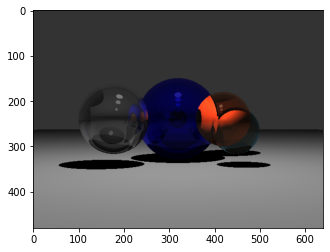

In [0]:
if __name__ == "__main__":
    random.seed(13)
    spheres = []
    #position, radius, surface color, reflectivity, transparency, emission color
    spheres.append(Sphere(np.array([ 0.0, -10004, -20]), 10000, np.array([0.20, 0.20, 0.20]),0,0))
    spheres.append(Sphere(np.array([ 0.0, 0, -20]), 4, np.array([1.0, 0.32, 0.36]),1,0.5))
    spheres.append(Sphere(np.array([ 5.0, -1, -15]), 2, np.array([0.90, 0.76, 0.46]), 1,0))
    spheres.append(Sphere(np.array([ 5.0, 0, -25]), 3, np.array([0.65, 0.77, 0.97]),1,0))
    spheres.append(Sphere(np.array([ -5.5, 0, -15]), 3, np.array([0.90, 0.90, 0.90]), 1,0))
    #light
    spheres.append(Sphere(np.array([ 0.0, 20, -10]), 3, np.array([0.0,0.0,0.0]), 0,0, np.array([3.0,3.0,3.0])))
    start = time.time()
    render(spheres)
    print(f'total time for rendering:{time.time()-start} seconds')